

# Fourier Analysis in NT and Markets

In this warmup notebook, we compare the application of Fourier series analysis in Number Theory and market data.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
import scipy.stats as stats
import yfinance as yf
import datetime as dt

In [3]:
def von_Mangoldt(N):
    #Return an np.array Lambda[0,1,...,N], where Lambda is a simplified von mangoldt function, taking log value on primes. With the convention \Lambda(0)=0
    Lam=np.zeros(N, dtype=float)
    is_prime=np.ones(N+1, dtype=bool)

    for p in range(2, N):
        if not is_prime[p]:
            continue
        is_prime[p*p::p]=0
        Lam[p]=log(p)
    return Lam

By the Prime-Number Theorem, the sum of von Mangoldt up to N should be around N.

In [4]:
primo=9699690 #2*3*5*7*11*13*17*19

N=primo*1 #Chosing a multiple of primorial, to make the effect of small prime divisor of frequency denominator better visible.

Lambda=von_Mangoldt(N)
print("N:", N, "sum Lambda:", Lambda.sum())

N: 9699690 sum Lambda: 9696470.977783008


Calculate some basic stats, which are of course not very suitable for $\Lambda$, but useful for later comparison with SPY data.

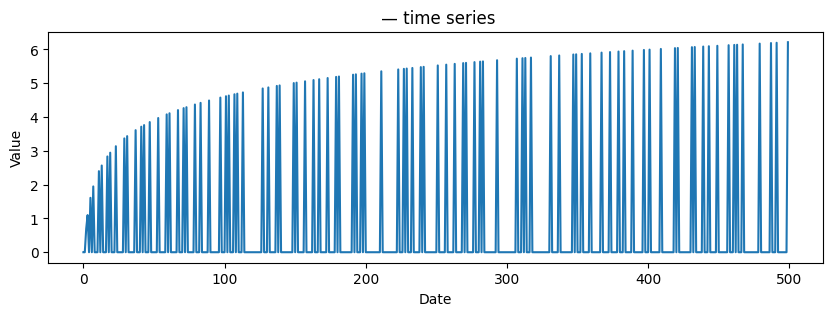

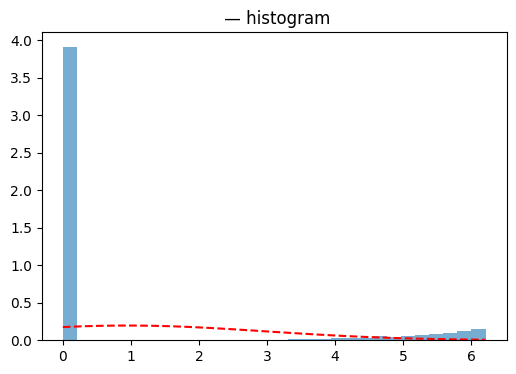

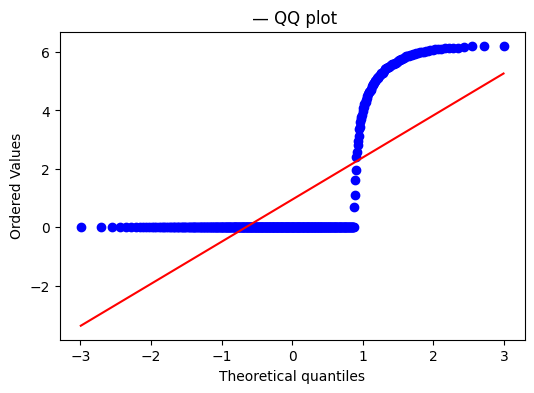

Mean is 0.9491088883093884 SD is 2.0274903431974143


In [5]:
def plot_column_distribution(x):

    # Time series (index on x-axis)
    plt.figure(figsize=(10,3))
    plt.plot(x)
    plt.title(f" — time series")
    plt.xlabel(f"Date")
    plt.ylabel("Value")
    plt.show()

    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=30, density=True, alpha=0.6)
    mu, sigma = x.mean(), x.std(ddof=1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), "r--")
    plt.title(f" — histogram")
    plt.show()

    # QQ plot
    plt.figure(figsize=(6,4))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f" — QQ plot")
    plt.show()

    print(f'Mean is {x.mean()}', f'SD is {x.std()}')

plot_column_distribution(Lambda[0:500])

We next calculate $\hat{\Lambda}(\alpha)=\sum_{n\leq N}\Lambda(n) e^{2\pi i \alpha n}$

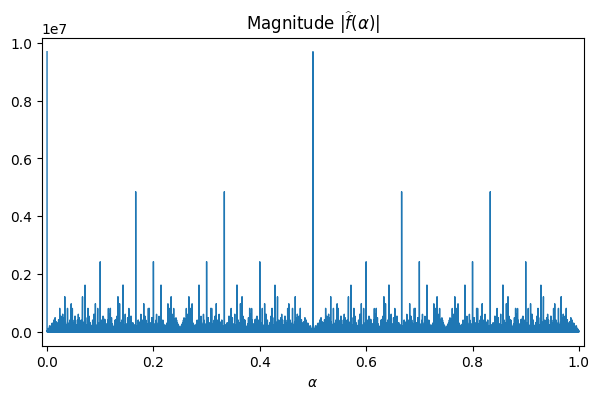

In [6]:
def hat(Array):
    #Simple fft that return alpha value and fourier transform. No padding or hann window.
    N=len(Array)
    alphas=np.arange(N)/N
    X=np.fft.fft(Array)
    return alphas, X

def plot_spectrum(f):
    alphas, X=hat(f)
    mag=np.abs(X)
    plt.figure(figsize=(7,4))
    plt.plot(alphas, mag, lw=1)
    plt.xlim(-0.01, 1.01)
    plt.xlabel(r'$\alpha$')
    plt.title(r'Magnitude $|\widehat{f}(\alpha)|$')
    plt.show()

plot_spectrum(Lambda)

We know that $|\hat{\Lambda}(\alpha)|$ should be of size $N/q$ if $\alpha$ is close to a rational number with denominator $q$. Let's extract this information numerically.

In [7]:

def large_spec(f, rel_size=0.01, leak_fix=0): #The leakage paramter is used to surpress the issue of clustering of spectrum near 0 and 1 in the volseq data below.
    alphas, X=hat(f)
    mag=np.abs(X)
    thresh = rel_size * float(mag.max())
    large= mag > thresh
    print(f'The maximum magnitude is {mag.max()}, there are {large.sum()} out of {alphas.shape[0]} large signals')
    padded=np.r_[0, large.view(np.int8), 0] #reinterpret Bool as int values, and add 0 at beginning and end
    diff= np.diff(padded)  #Differentiate to discover runs
    starts= np.where(diff == 1)[0]
    ends= np.where(diff == -1)[0]
    sel_indices = []
    for s, e in zip(starts, ends):
        # choose index of max magnitude inside cluster
        cluster_idx = np.arange(s, e)
        local_idx = cluster_idx[np.argmax(mag[cluster_idx])]
        sel_indices.append(int(local_idx))
    sel_indices = np.array(sel_indices, dtype=int)

    if leak_fix > 0 and sel_indices.size > 0: #Implementing the leak fix in a naive manner.

        # bin index for each selected frequency
        bins = (alphas[sel_indices] / leak_fix).astype(int)

        new_sel = []
        for b in np.unique(bins):
            idx = sel_indices[bins == b]
            best = idx[np.argmax(mag[idx])]
            new_sel.append(best)

        sel_indices = np.array(new_sel, dtype=int)
        print(f"Applied leak_fix with bin width = {leak_fix}, left with {sel_indices.shape[0]} frequencies")
    order = np.argsort(-np.abs(X[sel_indices]))
    sel_indices = sel_indices[order]
    return alphas[sel_indices],X[sel_indices]



Testing some values:

In [8]:
lsLambda=large_spec(Lambda)
print(lsLambda[0][:10])
print(lsLambda[1][:10])

The maximum magnitude is 9696470.977783008, there are 4538 out of 9699690 large signals
[0.         0.5        0.66666667 0.33333333 0.16666667 0.83333333
 0.8        0.2        0.7        0.3       ]
[ 9696470.97778301+0.00000000e+00j -9696469.59148864-9.37916411e-11j
 -4848233.84097307-2.59042928e+03j -4848233.84097307+2.59042928e+03j
  4848233.14782589+2.58922871e+03j  4848233.14782589-2.58922871e+03j
 -2426052.65135568+9.47633917e+02j -2426052.65135568-9.47633917e+02j
  2426051.52981998+9.46819073e+02j  2426051.52981998-9.46819073e+02j]


We extract next a physical space approximant that capture behaviours at large Fourier frequencies, via
$$\Lambda_{\approx}=\Lambda*K(n),$$
where
$$K(n)=\sum_{\alpha \in \mathcal{S}} e(\alpha n)\frac{1_{|n|\leq L}}{2L+1}.$$

Since physical (time) space convolution requires $LN=cN^2$ ($c$ is scale below) steps, it is not feasible. Instead we use multiplication in frequency space and inverse Fourier, making use of the fact that FFT has time complexity $O(N\log N)$.

In [9]:
def fou_approx(f, rel_size=0.01, leak_fix=0, R=10, scale=0.1):
    #Inclusion of a scale means we carry information more than $1/N$ away from peaks. This is mathematically meaningful, since one can only show smallness of \hat{\Lambda} if we are sufficiently away from peaks.

    largalpha=large_spec(f, rel_size=rel_size, leak_fix=leak_fix)[0][:R]

    def _next_pow2(x):
        x = int(x)
        if x <= 1:
            return 1
        return 1 << ((x - 1).bit_length())

    N = f.shape[0]
    Y = min(int(R), len(largalpha))

    ZN = int(np.floor(scale * N))
    if ZN < 0:
        ZN = 0

    alphas = np.array(largalpha[:Y], dtype=float)  # selected alphas
    Klen = 2 * ZN + 1                              # kernel length (t = -ZN..ZN)

    if Y == 0 or Klen == 0:
        return np.zeros(N, dtype=float)


    t = np.arange(-ZN, ZN + 1)                     # length Klen
    K_time = np.exp(2j * np.pi * np.outer(alphas, t)).sum(axis=0).astype(np.complex128) #This creates the function K in time (physical) domain, by first creating a matrix of pairs and summing then.


    L = N + Klen - 1
    M = _next_pow2(L)                                #We create a power of 2 that contains the maximal time space length required for the linear convolution. Standard FFT should use binary splitting, so this is the best choice trading run time and precision.

    # use complex FFTs because K_time is complex
    A = np.fft.fft(f, n=M)
    B = np.fft.fft(K_time, n=M)
    conv_full = np.fft.ifft(A * B, n=M).real[:L]   #  convolution result

    # 'same' slice: align t=0 with index ZN -> take conv_full[ZN:ZN+N]
    start = ZN
    end = ZN + N
    conv_same = conv_full[start:end]

    # counts (averaging divisor): convolution of ones(N) with ones(Klen) via FFT. Thus normalising by unit interval convolution
    ones_N = np.ones(N, dtype=float)
    ones_K = np.ones(Klen, dtype=float)
    C = np.fft.ifft(np.fft.fft(ones_N, n=M) * np.fft.fft(ones_K, n=M), n=M).real[:L]
    counts = C[start:end]
    counts[counts == 0] = 1.0

    fapprox = conv_same / counts
    return fapprox

Lapprox = fou_approx(Lambda, R=20)


The maximum magnitude is 9696470.977783008, there are 4538 out of 9699690 large signals


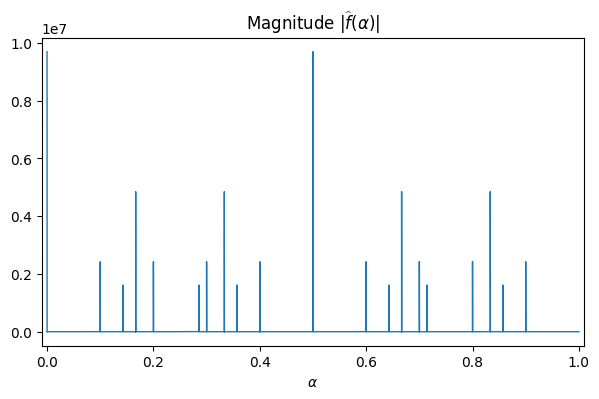

In [10]:
plot_spectrum(Lapprox) #We should see the peaks from before.

Having confirmed that the spectral lines match the peaks, we gather some statistics.

In [11]:
def fit_stats(F, Fapprox):
    F = np.asarray(F, float)
    Fapprox = np.asarray(Fapprox, float)
    Fres=F-Fapprox

    L2=np.linalg.norm(Fres)
    rel_L2=L2/np.linalg.norm(F)

    Fc=F-F.mean()
    R2=1.0-(L2**2)/(np.linalg.norm(Fc)**2)

    resabs=np.abs(Fres)

    out = {
        "rel_L2": rel_L2,
        "R2_explained_var": R2,
        "RMSE": np.sqrt(np.mean(Fres*Fres)),
        "MAE": np.mean(resabs),
        "MedAE": np.median(resabs),
        "Q95_AE": np.quantile(resabs, 0.95),
        "Linf": np.max(resabs),
    }
    df = pd.DataFrame(out, index=["value"]).T
    return df

print(fit_stats(Lambda, Lapprox))



                      value
rel_L2             0.870080
R2_explained_var   0.189244
RMSE               3.379111
MAE                1.770452
MedAE              0.332872
Q95_AE            10.873033
Linf              12.944322


The most interesting stat is here the $19$% explained variance with only few frequencies.
## SPY Data
Let's see what happens if we apply the same methodology to SPY data next.

In [12]:
#Importing the YF SPY minute data in the last week
end = dt.datetime.now()
start = end - dt.timedelta(days=8)
data = yf.download(
    tickers="SPY",
    start=start,
    end=end,
    interval="1m",
    progress=False,
    auto_adjust=True
)

In [13]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Datetime,,,,,
2025-12-31 15:37:00+00:00,685.330017,685.494995,685.255005,685.479980,0
2025-12-31 15:38:00+00:00,685.169983,685.330017,685.119995,685.320007,96061
2025-12-31 15:39:00+00:00,685.130005,685.219971,685.109985,685.169983,181997
2025-12-31 15:40:00+00:00,685.020020,685.150024,684.940002,685.099976,148540
2025-12-31 15:41:00+00:00,685.049988,685.119995,684.961975,685.030029,249830


Inspection below reveals that the logarithmic differences, mean normalised as well as the logarithmic volume, mean normalised, behave closer to a reasonable distribution than without those normalisations. Furthermore, the volume data exhibits more periodic structure, so we focus on it.

In [16]:
closeseq=data['Close'].to_numpy().ravel()
closediff=np.diff(np.log(closeseq)) #Differences of logarithmic returns
closediff=closediff-closediff.mean() #Possible mean subtraction.
volseq=data['Volume'].to_numpy().ravel()
volseq=np.log(volseq+1)
volseq=volseq-volseq.mean() #Necessary, because the 0 peak is else overwhelming.


[-11.75188675  -0.27913766   0.35986422   0.15672954   0.67665322
  -0.24274845  -0.20325636   0.98782725   0.36702541   0.26268635
  -0.34974761  -0.1055149    0.1856788    0.1756023   -0.11667286]


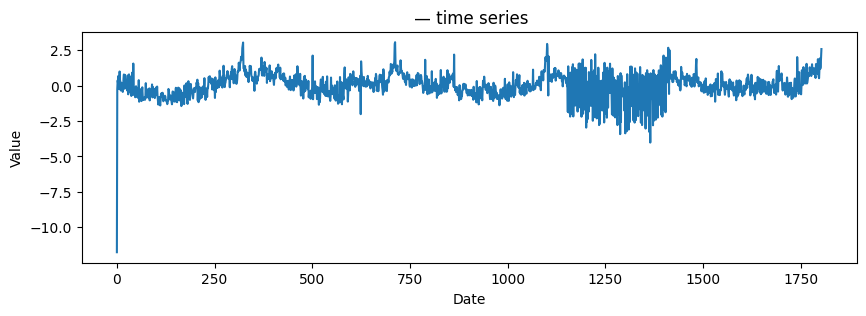

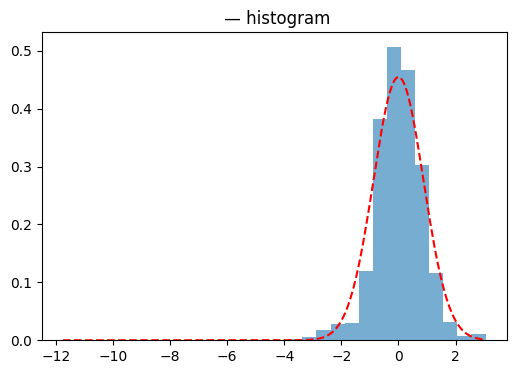

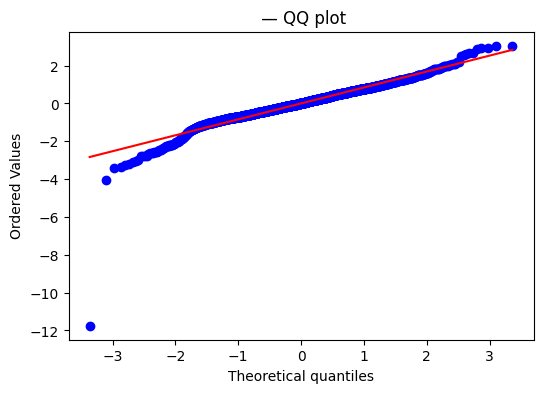

Mean is 1.5676053704685137e-15 SD is 0.8768399404986723


In [17]:
print(volseq[:15])
#print(closediff[:15])
plot_column_distribution(volseq)
#plot_column_distribution(closediff)

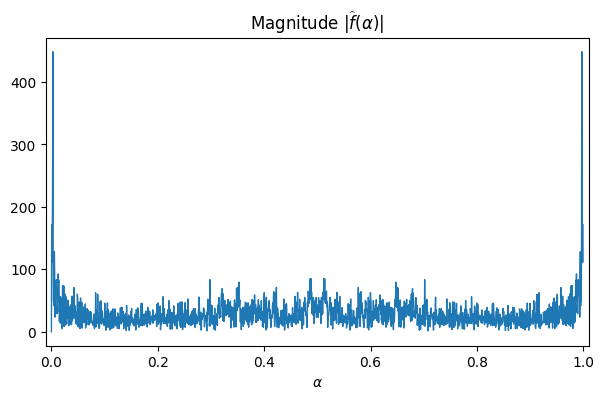

In [18]:
#plot_spectrum(closediff)
plot_spectrum(volseq)

Next define set of large spectrum.

In [20]:
#large_spec(closediff, rel_size=0.6) #Call function to determine good rel_size choice
large_spec(volseq, rel_size=0.1, leak_fix=0.05)


The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies


(array([0.99722838, 0.00277162, 0.51219512, 0.48780488, 0.29822616,
        0.70177384, 0.64745011, 0.35254989, 0.422949  , 0.577051  ,
        0.3481153 , 0.6518847 , 0.08314856, 0.91685144, 0.21008869,
        0.78991131, 0.89467849, 0.10532151, 0.83093126, 0.16906874]),
 array([448.15351922-18.50045898j, 448.15351922+18.50045898j,
        -79.3754705 +31.3132533j , -79.3754705 -31.3132533j ,
        -77.42717384-31.04238184j, -77.42717384+31.04238184j,
        -76.90555268+19.7969899j , -76.90555268-19.7969899j ,
        -40.20679327+58.59644814j, -40.20679327-58.59644814j,
        -68.50614248+13.99721077j, -68.50614248-13.99721077j,
        -61.15621065+13.1472812j , -61.15621065-13.1472812j ,
        -54.76574581-12.02910714j, -54.76574581+12.02910714j,
         14.83446072-43.4058638j ,  14.83446072+43.4058638j ,
        -25.84639581+37.78868142j, -25.84639581-37.78868142j]))

We see a clustering of frequencies near $0$ and $1$, implying that our leakage elmination in the large spectrum identification does not work completely. The best solution would be to replace the absolute magnitude selection by  local contrast. For the moment I have implement a naive leakage fix.

In [22]:
testR=[1,5,10,20]

for r in testR:
    approx =  fou_approx(volseq, rel_size=0.1, leak_fix=0.05, R=r, scale=0.3)
    print(f'For R={r}')
    print(fit_stats(volseq, approx))

The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies
For R=1
                      value
rel_L2             0.925077
R2_explained_var   0.144232
RMSE               0.811145
MAE                0.563828
MedAE              0.439821
Q95_AE             1.599915
Linf              12.039145
The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies
For R=5
                      value
rel_L2             0.889036
R2_explained_var   0.209615
RMSE               0.779542
MAE                0.535648
MedAE              0.393267
Q95_AE             1.540919
Linf              12.217800
The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies
For R=10
                      value
rel_L2             0.882855
R2_explained_var   0.220

In [68]:
testR=[1,5,10,20,30]
for r in testR:
    approx =  fou_approx(Lambda, rel_size=0.1, R=r, scale=0.1)
    print(f'For R={r}')
    print(fit_stats(Lambda, approx))

The maximum magnitude is 9696470.977783008, there are 54 out of 9699690 large signals
For R=1
                         value
rel_L2            9.663044e-01
R2_explained_var -1.086824e-07
RMSE              3.752818e+00
MAE               1.866195e+00
MedAE             9.997216e-01
Q95_AE            1.359368e+01
Linf              1.508854e+01
The maximum magnitude is 9696470.977783008, there are 54 out of 9699690 large signals
For R=5
                      value
rel_L2             0.899730
R2_explained_var   0.133045
RMSE               3.494264
MAE                1.799778
MedAE              0.499845
Q95_AE            11.844973
Linf              13.340574
The maximum magnitude is 9696470.977783008, there are 54 out of 9699690 large signals
For R=10
                      value
rel_L2             0.885800
R2_explained_var   0.159682
RMSE               3.440166
MAE                1.674439
MedAE              0.042292
Q95_AE            11.204408
Linf              13.401620
The maximum magnitude

# Random surrogate comparison
Let's compare those values against random surrogate models:
1. i.i.d bootstrap
2. gaussian
3. phase randomised
4. block bootstrap


In [23]:
rng = np.random.default_rng(42)

def sur_bootstrap(y, rng):
    y = np.asarray(y, float)
    return rng.choice(y, size=y.size, replace=True)

def sur_gaussian(y, rng):
    y = np.asarray(y, float)
    return rng.normal(loc=y.mean(), scale=y.std(ddof=1), size=y.size)

def sur_phase(y, rng):
    y = np.asarray(y, float)
    n=y.size
    Y=np.fft.fft(y)

    phases= rng.uniform(0.0, 2*np.pi, size=Y.size)
    Y_new=phases*Y
    y_new=np.fft.ifft(Y_new)

    return np.real(y_new)

testR=[1,5,11]

def sur_comp(f, testR=[1,5,10], rng=rng, rel_size=0.1, leak_fix=1, scale=0.1):
    print(f'Looking at original function')
    for r in testR:
        approx =  fou_approx(f, rel_size=rel_size, R=r, leak_fix=leak_fix, scale=scale)
        print(f'For R={r}')
        print(fit_stats(volseq, approx))

    surs = {
    "boot": sur_bootstrap(f, rng),
    "gauss": sur_gaussian(f, rng),
    "phase": sur_phase(f, rng),
    }

    for name, g in surs.items():
        print(f'Looking at {name} surrogate')
        for r in testR:
            gapprox =  fou_approx(g, rel_size=rel_size, R=r, leak_fix=leak_fix, scale=scale)
            print(f'For R={r}')
            print(fit_stats(g, gapprox))

In [26]:
testR=[1,5,10,20]

sur_comp(volseq, testR=testR, rel_size=0.1, leak_fix=0.05, scale=0.3)



Looking at original function
The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies
For R=1
                      value
rel_L2             0.925077
R2_explained_var   0.144232
RMSE               0.811145
MAE                0.563828
MedAE              0.439821
Q95_AE             1.599915
Linf              12.039145
The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies
For R=5
                      value
rel_L2             0.889036
R2_explained_var   0.209615
RMSE               0.779542
MAE                0.535648
MedAE              0.393267
Q95_AE             1.540919
Linf              12.217800
The maximum magnitude is 448.5352202123566, there are 268 out of 1804 large signals
Applied leak_fix with bin width = 0.05, left with 20 frequencies
For R=10
                      value
rel_L2             0.88

As we can see, there is better than random explained variance in the minute returns, implying some periodicity (for example with frequencies close to $a/5$ when we have $5$ trading day, thus interday similarities)